                190426_Dura  190426_2  190426_3  190426_4  190426_5  190426_6  \
chr22_29636758            1         1         1         1         1         1   
chr1_17425675             1         0         0         0         0         0   
chr1_235980591            1         0         0         0         0         0   
chr2_100975407            1         0         0         0         0         0   
chr6_148533864            1         0         0         0         0         0   
...                     ...       ...       ...       ...       ...       ...   
chr16_61055586            0         0         0         0         1         1   
chr20_44466662            0         0         0         0         1         1   
chr20_44466665            0         0         0         0         1         1   
chr20_44466688            0         0         0         0         1         1   
chr5_39110447             0         0         0         0         0         0   

                190426_7  1

ValueError: The number of FixedLocator locations (102), usually from a call to set_ticks, does not match the number of labels (203).

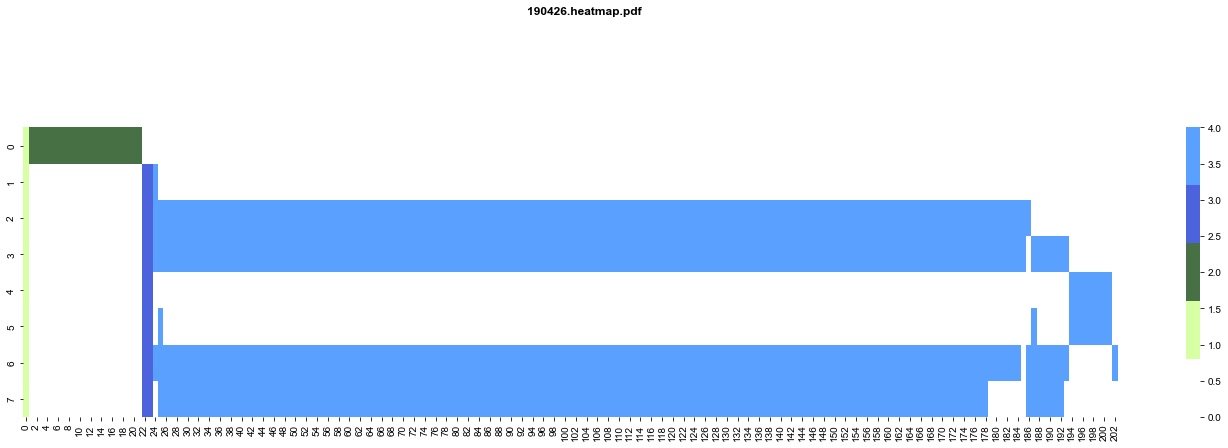

In [3]:
import os, subprocess, argparse
import pandas as pd
import numpy as np
import vcf, pysam
from scipy.stats import binom
from matplotlib.colors import ListedColormap

kwargs = {}

kwargs["BCFTOOLS_MERGE_OUTPUT_VCF"] = "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/190426.merge.vcf"
kwargs["OUTPUT_REDUCTION_DF_PATH"] = "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/190426.reduction_df.tsv"
kwargs["OUTPUT_HEATMAP_PATH"] = "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/190426.heatmap.pdf"
kwargs["OUTPUT_DENDROGRAM_PATH"] = "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/190426.dendrogram.pdf"

# kwargs["BCFTOOLS_MERGE_OUTPUT_VCF"] = "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/230405.merge.vcf"
# kwargs["OUTPUT_REDUCTION_DF_PATH"] = "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/230405.reduction_df.tsv"
# kwargs["OUTPUT_HEATMAP_PATH"] = "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/01.BCFTOOLS_MERGE_TXT/230405.heatmap.pdf"
# kwargs["OUTPUT_DENDROGRAM_PATH"] = "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/01.BCFT|OOLS_MERGE_TXT/230405.dendrogram.pdf"


####################################################################################################################################


def find_not_blood_sample(samplenames):
  li = []
  for i, name in enumerate(samplenames):
    if "Blood" not in name:
        li.append (i)
  return li


import pandas as pd
import vcf

vcf_reader = vcf.Reader(open( kwargs["BCFTOOLS_MERGE_OUTPUT_VCF"], "r"))
samplenames = vcf_reader.samples
not_blood_sample_i = find_not_blood_sample ( samplenames )

#samplename_interest = ['190426_Dura',  '190426_2',   '190426_4', '190426_6' , '190426_7'    ]
samplename_interest = ['190426_Dura',   '190426_2', '190426_3',  '190426_4',  '190426_5', '190426_6' , '190426_7', '190426_8'    ]
#samplename_interest = ['230405_2_Dura', '230405_1',  '230405_2',   '230405_3',  '230405_4',  '230405_5',  '230405_6',   '230405_7',  '230405_8'   ]
df = pd.DataFrame ( columns = samplename_interest )            # Blood가 아닌 샘플들에 대해서만 집어넣겠다
df_depth = pd.DataFrame ( columns = samplename_interest )
df_alt = pd.DataFrame ( columns = samplename_interest )
df_SCITE = pd.DataFrame ( columns = samplename_interest )

chrpos,chrpos_Sequoia = [], []

for line in vcf_reader:
    CHR = line.CHROM
    POS = str (line.POS)
    REF, ALT = str(line.REF), str( line.ALT[0] )

    matrix, matrix_alt, matrix_depth, matrix_SCITE = [], [], [], []
    for sample_i, samplename in enumerate (samplenames):
        if samplename not in samplename_interest:
            continue

        if line.samples [sample_i].data.GT in ["./.", "."]:
            matrix.append ( 0 )
            matrix_alt.append(  0  )
            matrix_depth.append(  100  )
            matrix_SCITE.append ( 3 )
        
        elif line.samples [sample_i].data.GT in [ "0/0", "0|0"]:
            matrix.append ( 0 )
            matrix_alt.append(  0  )
            matrix_depth.append(  100  )
            matrix_SCITE.append ( 0 )
        else:
            matrix.append ( 1  )
            if "Dura" in samplename:
                matrix_alt.append(  int(line.samples [sample_i].data.DP / 2)  )
            else:
                matrix_alt.append(  line.samples [sample_i].data.AD[1]  )
            matrix_depth.append(  line.samples [sample_i].data.DP  )
            matrix_SCITE.append ( 1 )

    if np.sum(matrix) != 0:
        df.loc [ len(df.index) ] =  matrix      # 한줄씩 집어넣기
        df_alt.loc [ len(df_alt.index) ] =  matrix_alt      # 한줄씩 집어넣기
        df_depth.loc [ len(df_depth.index) ] =  matrix_depth      # 한줄씩 집어넣기
        df_SCITE.loc [ len(df_SCITE.index) ] =  matrix_SCITE      # 한줄씩 집어넣기
        chrpos.append ( CHR + "_" + POS )
        chrpos_Sequoia.append ( CHR.replace("chr", "") + "_" + POS + "_" + REF + "_" + ALT)
df.index =  chrpos
df_alt.index =  chrpos_Sequoia
df_depth.index =  chrpos_Sequoia

df = df.sort_values(by = df.columns.tolist(), ascending=False)
# df_alt = df_alt.sort_values(by = df_alt.columns.tolist(), ascending=False)
# df_depth = df_depth.sort_values(by = df_depth.columns.tolist(), ascending=False)

df.to_csv ( kwargs["OUTPUT_HEATMAP_PATH"].replace("pdf", "tsv"), sep = "\t")
df_alt.iloc[:, :].to_csv ( kwargs["OUTPUT_HEATMAP_PATH"].replace(".pdf", ".alt.tsv"), sep = "\t")
df_depth.iloc[:, :].to_csv ( kwargs["OUTPUT_HEATMAP_PATH"].replace(".pdf", ".depth.tsv"), sep = "\t")
df_SCITE.iloc[:, 1:].T.to_csv ( kwargs["OUTPUT_HEATMAP_PATH"].replace(".pdf", ".SCITE.tsv"), sep = "\t", index = False, header = False)



print (df)


############# 주영석샘 논문대로 reduced count matrix 만들어주기 #######################
np_matrix = np.array (df)
np_matrix_reduction = []
binary_string_dict = {}
for i in range ( np_matrix.shape[0] ):
    binary_string = ''.join(map(str, np_matrix[i] ))
    if binary_string in binary_string_dict.keys():
        binary_string_dict [ binary_string ] += 1
    else:  # 처음보는 것일 때
        binary_string_dict [ binary_string ] = 1
        if i != 0:
            np_matrix_reduction.append ( np_matrix[i - 1]  *  binary_string_dict  [ ''.join(map(str, np_matrix[ i - 1 ] ))  ]    )
np_matrix_reduction.append ( np_matrix[i - 1]  *  binary_string_dict  [ ''.join(map(str, np_matrix[ i - 1 ] ))  ]    )

df_reduction = pd.DataFrame ( np.array ( np_matrix_reduction ), columns =  df.columns ) 
df_reduction.to_csv ( kwargs["OUTPUT_REDUCTION_DF_PATH"] , sep = "\t", index = False)


############# Clone, subclone 별로 색깔 다륵 ㅔ해주기 ########################33

np_matrix = np.array (df)
for i in range ( np_matrix.shape[0] ) :
    if all ( np_matrix [ i ] == 1):
        np_matrix [ i ] = 1
    elif ( np_matrix[ i ][0] == 1 ) & ( all ( np_matrix [ i ][1:] == 0) ) :
        np_matrix [ i ][ 0 ] = 2
    elif ( np_matrix[ i ][0] == 0 ) & ( all ( np_matrix [ i ][1:] == 1) ) :
        np_matrix [ i ][ 1: ] = 3
    else:
        for j in range (np_matrix.shape[1]):
            if np_matrix [ i ] [ j ]  == 1:
                np_matrix [ i ][ j ] = 4

# 너무 많으니까 몇 개만 추리자
pos_index_list = []
#for i in range ( np_matrix.shape[0] ) :
    # if np.sum (np_matrix [i] ) == 4 :
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_3') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_4') [0][0] ] == 4)  & (np_matrix [i] [ np.where ( df.columns == '190426_7') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_8') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 16 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_3') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_4') [0][0] ] == 4)  & (np_matrix [i] [ np.where ( df.columns == '190426_7') [0][0] ] == 4) &  ( np.sum ( np_matrix [i] )  == 12 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_4') [0][0] ] == 4)  & (np_matrix [i] [ np.where ( df.columns == '190426_7') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_8') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 12 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_3') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_4') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 8 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_5') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_6') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 8 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_7') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_8') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 8 ):
    #     pos_index_list.append ( i )
    # if (np_matrix [i] [ np.where ( df.columns == '190426_4') [0][0] ] == 4) & (np_matrix [i] [ np.where ( df.columns == '190426_7') [0][0] ] == 4)  &  ( np.sum ( np_matrix [i] )  == 8 ):
    #     pos_index_list.append ( i )

pos_index_list  = sorted ( list ( set ( range ( np_matrix.shape[0]) ) - set (pos_index_list) ) )   # 나머지만 보겠다

np_matrix = np_matrix [ pos_index_list, :]


#def HEATMAP_VISUALIZATION (df, title, Output_filename, **kwargs):
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

title = kwargs["OUTPUT_HEATMAP_PATH"].split("/")[-1]
Output_filename = kwargs["OUTPUT_HEATMAP_PATH"]

plt.rcParams["font.family"] = 'arial'

# Define the colors
fig, ax = plt.subplots ( nrows = 1, ncols = 1, figsize =(25 , 6 ))

# Create the colormap
cmap_dict = { 0: "white", 1: "#D7FFA4", 2: "#477045", 3: "#4D63DD", 4: "#5AA0FF" }

fig.subplots_adjust ( wspace = 0.4, bottom = 0.03, top = 0.7, left = 0.22, right = 0.98)
fig.set_facecolor('white')
sns.heatmap ( np_matrix.T, cmap = ListedColormap([ cmap_dict[i] for i in range(5)])  , linewidths = 0, linecolor = "black" )   # fmt=".2f", 
    
    
fig.suptitle ( title, fontsize = 12, fontweight = "bold", ha = "left", x = 0.5 )
ax.set_xticklabels( [ df.index[i] for i in pos_index_list ] , fontsize = 12, ha = 'left' )
ax.tick_params(axis = 'x',  rotation = 45)
ax.set_yticklabels( [ i.split("_")[-1] for i in df.columns], fontsize = 12, va = 'center' )
ax.tick_params(axis = 'y',  rotation = 0)


plt.tick_params(axis = 'both', which = 'major', labelsize = 12, left = False, labelbottom = False, bottom=False, top = False, labeltop=True)

fig.savefig ( Output_filename, dpi = 300)

---

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the dendrogram
def HierichialClustering (df, colnames, title, OUTPUT_FILEPATH ):
    fig, ax = plt.subplots(1, 1, figsize = (8 / 2.54, 15 / 2.54))
    fig.subplots_adjust (wspace = 0.2, hspace = 0.8, bottom = 0.35, top = 0.85, left = 0.15, right = 0.95)
    sns.set_style("white")
    plt.rcParams['lines.linewidth'] = 6
    plt.rcParams["font.family"] = 'arial'

    def my_label_func ( leaf_label ):  # 0, 1, 2, 3
        return colnames [leaf_label ]

    D = scipy.cluster.hierarchy.dendrogram(
        scipy.cluster.hierarchy.linkage( df, method = 'ward', metric = 'euclidean'),
        leaf_label_func = my_label_func,  # column 이름 정하기
        leaf_rotation = 90  # Rotate labels for better readability
    )

    ax.tick_params(axis = 'x', rotation = 90 )
    ax.set_xticklabels ( ax.get_xticklabels() , fontsize = 10, fontweight = "bold", ha = "right"  ) 
    ax.set_yticklabels ( ax.get_yticklabels() , fontsize = 10, fontweight = "bold"  ) 
    ax.set_title('Hierarchical Clustering : {}'.format (title), fontweight = "semibold", fontsize = 14)
    ax.set_ylabel('Distance')

    for axis in ['left','bottom', 'right', 'top']:
        ax.spines[axis].set_linewidth (1.5)
    sns.despine ( top = True, right = True, ax = ax)
    plt.savefig (OUTPUT_FILEPATH)

################################################################################################################


HierichialClustering ( df.T.iloc [1:, :] ,  list ( df.columns )[1:], "binary",  kwargs["OUTPUT_DENDROGRAM_PATH"] )       # Binary 를 넣었을 때
# HierichialClustering ( d_vaf,  list ( d_binary.index ),  "vaf", "/data/project/Meningioma/script/03.Variant_calling&Annotation/190426.dendrogram.vaf.pdf" )                       # Scaling 한 AF 를 넣었을 때
# HierichialClustering ( d_scale, list ( d_binary.index ),  "scale",  "/data/project/Meningioma/script/03.Variant_calling&Annotation/190426.dendrogram.scale.pdf" )        # Scaling 안한 AF를 넣었을 떄

/opt/Yonsei/python/3.8.1/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


NameError: name 'df' is not defined

---

### Germline concordance pre-process

In [3]:
import tqdm

class Sample:
    def __init__ (self, Sample_ID, HC_DIR, Clone_No, OUTPUT_PATH, OUTPUT_HEATMAP_PATH):
        self.Sample_ID = Sample_ID
        self.HC_DIR = HC_DIR
        self.Clone_No = Clone_No
        self.output_file = OUTPUT_PATH
        self.output_heatmap = OUTPUT_HEATMAP_PATH
        self.input_file = []
        for Clone_No in self.Clone_No:
            self.input_file.append ( self.HC_DIR + "/" + self.Sample_ID + "_" + str(Clone_No) + ".hc.VF.vcf" )
        self.input_file.sort()
        self.name_list = []
        self.whole_dic = {}
    
    def  get_name (self ):
        for file in tqdm.tqdm( self.input_file ):
            name = file.split("/")[-1].split(".")[0]
            self.name_list.append(name)
            self.whole_dic[name] = set()
    
            f = open( file, 'r' )
            for fline in f:
                if fline.startswith('#'):
                    continue
                ftab = fline.rstrip().split('\t')
                ID = ftab[0] + '_' + ftab[1]    #"CHR.POS"
                self.whole_dic[name].add(ID)
            f.close()


    def  running (self ):
        first_list = list( self.name_list )
        second_list = list( self. name_list )

        fo = open( self.output_file, 'w')
        fo.write('concor' + '\t')
        for first in first_list:
            if first == first_list[-1]:
                fo.write(first + '\n')
            else:
                fo.write(first + '\t')

        for first in first_list:
            fo.write(first + '\t')
            for second in second_list:
                if second == second_list[-1]:
                    if first == second:
                        fo.write('100' + '\n')
                    else:
                        concordance = round(len(self.whole_dic[first] & self.whole_dic[second])/len(self.whole_dic[first] | self.whole_dic[second]) * 100, 2)
                        fo.write(str(concordance) + '\n')

                else:
                    if first == second:
                        fo.write('100' + '\t')
                    else:
                        concordance = round(len(self.whole_dic[first] & self.whole_dic[second])/len(self.whole_dic[first] | self.whole_dic[second]) * 100, 2)
                        fo.write(str(concordance) + '\t')
        fo.close()

        cor_df = pd.read_csv ( self.output_file, sep ="\t", index_col = 0 )
        cor_df.style.background_gradient(cmap ='coolwarm').set_precision(1)

        from matplotlib.colors import LinearSegmentedColormap
        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.rcParams["font.family"] = 'arial'
        fig,ax =plt.subplots (nrows = 1, ncols = 1, figsize = (10, 4))
        sns.heatmap (cor_df,  cmap  = 'coolwarm'  , annot = cor_df,  fmt='.1f' , annot_kws = {"fontsize" : 13}, linewidths = 0, linecolor = "black", ax = ax )   # fmt=".2f", 
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12, left = False, labelbottom = False, bottom=False, top = False, labeltop=True)
        fig.savefig ( self.output_heatmap , dpi = 300) 

        

### Germline concordance running (Single HC)

100%|██████████| 8/8 [00:00<00:00, 12.28it/s]
<ipython-input-3-af3829b782d2>:64: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cor_df.style.background_gradient(cmap ='coolwarm').set_precision(1)
100%|██████████| 8/8 [00:00<00:00, 12.62it/s]
<ipython-input-3-af3829b782d2>:64: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  cor_df.style.background_gradient(cmap ='coolwarm').set_precision(1)


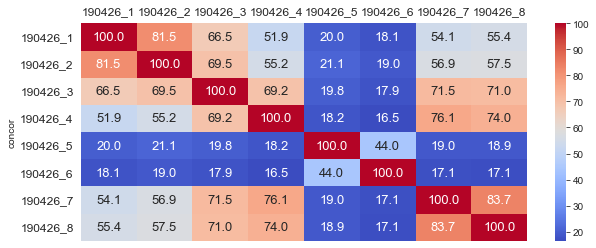

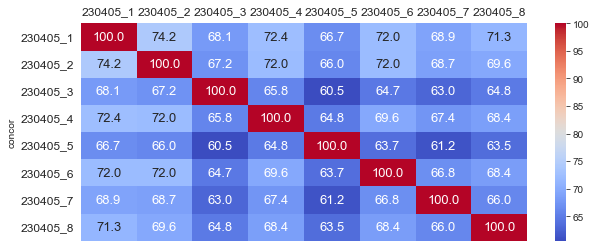

In [4]:
Sample_190426 = Sample ( "190426", "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/02.VariantFiltration", ["1", "2", "3", "4", "5", "6", "7", "8"], "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/04.concordance/190426.concordance_df.txt", "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/04.concordance/190426.concordance_df.jpg" )
Sample_230405 = Sample ( "230405", "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/02.VariantFiltration", ["1", "2", "3", "4", "5", "6", "7", "8"], "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/04.concordance//230405.concordance_df.txt", "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/04.concordance//230405.concordance_df.jpg" )

Sample_190426.get_name()
Sample_190426.running()
Sample_230405.get_name()
Sample_230405.running()

### Germline concordance running (pick_somatic)

In [5]:
class Pick_somatic:
    def __init__ (self, Sample_ID, INPUT_PATH, OUTPUT_DF_PATH, OUTPUT_HEATMAP_PATH, samplename_interest ):
        self.Sample_ID = Sample_ID
        self.INPUT_PATH = INPUT_PATH
        self.OUTPUT_DF_PATH = OUTPUT_DF_PATH
        self.OUTPUT_HEATMAP_PATH = OUTPUT_HEATMAP_PATH
        self.samplename_interest = samplename_interest

        self.whole_dic = {}
        for samplename in self.samplename_interest:
            self.whole_dic[ samplename ] = set()

        vcf_reader = vcf.Reader(open ( self.INPUT_PATH , "r" ) )
        for record in vcf_reader:
            CHR, POS = record.CHROM, str (record.POS ) 
            ID = CHR + '_' + POS  
            for sample_i, samplename in enumerate (  vcf_reader.samples ):
                if samplename not in self.samplename_interest:
                    continue

                if record.samples [sample_i].data.GT not in ["./.", "0/0", "0|0"]:
                    self.whole_dic [ samplename ].add ( ID )
    
    def running (self):
        concordance = []
        for first_index, first in enumerate( list ( self.whole_dic.keys() ) ) :
            for second_index, second in enumerate ( list ( self.whole_dic.keys() )  ) :
                if first_index == second_index:
                    concordance.append ( 100 )
                else:
                    concordance.append ( round(len (self.whole_dic[first] & self.whole_dic[second]) / len(self.whole_dic[first] | self.whole_dic[second]) * 100, 2) )


        self.cor_df = pd.DataFrame( [ concordance [i:i + len(self.samplename_interest) ] for i in range(0, len(concordance ), len(self.samplename_interest))], index = self.samplename_interest, columns = self.samplename_interest ) 
        self.cor_df.to_csv ( self.OUTPUT_DF_PATH, sep = "\t" )

        from matplotlib.colors import LinearSegmentedColormap
        import seaborn as sns
        import matplotlib.pyplot as plt

        plt.rcParams["font.family"] = 'arial'
        fig,ax =plt.subplots (nrows = 1, ncols = 1, figsize = (10, 4))
        sns.heatmap ( self.cor_df,  cmap  = 'coolwarm'  , annot = self.cor_df,  fmt='.1f' , annot_kws = {"fontsize" : 13}, linewidths = 0, linecolor = "black", ax = ax )   # fmt=".2f", 
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12, left = False, labelbottom = False, bottom=False, top = False, labeltop=True)
        fig.savefig ( self.OUTPUT_HEATMAP_PATH , dpi = 300) 





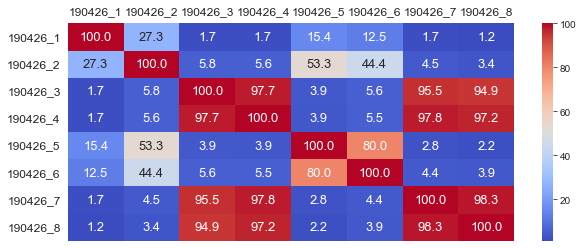

In [8]:
Somatic_190426 = Pick_somatic ( "190426", "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/05.pick_somatic/190426.pick_somatic.vcf", 
                                                        "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/04.concordance/190426.concordance_somatic_df.txt", 
                                                        "/data/project/Meningioma/61.Lowinput/01.XT_HS/06.HC/07.2D_merged/04.concordance/190426.concordance_somatic_df.jpg",
                                                        ['190426_1', '190426_2', '190426_3', '190426_4', '190426_5', '190426_6', '190426_7', '190426_8' ] )
Somatic_190426.running()

# Somatic_230405 = Pick_somatic ( "230405", "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/05.pick_somatic/230405.pick_somatic.vcf", 
#                                                         "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/04.concordance/230405.concordance_somatic_df.txt", 
#                                                         "/data/project/Meningioma/61.Lowinput/02.PTA/06.HC/07.2D_merged/04.concordance/230405.concordance_somatic_df.pdf",
#                                                         ['230405_1', '230405_2', '230405_3', '230405_4', '230405_5', '230405_6', '230405_7', '230405_8' ] )
# Somatic_230405.running()